# Repetition Codes on the BSC, BEC, and BI-AWGN Channel

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* The decoding performance of repetition codes
* The performance of reptition codes in the spectral efficiency chart

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.special import comb
import matplotlib.pyplot as plt

## Repetition Codes on the Hard BI-AWGN Channel / the BSC

We compare the performance of repetition codes of length $n$ ($n$ odd) over the __Hard BI-AWGN__ channel, which, as we have seen, is essentially a BSC with error probability $\delta = Q(\frac{1}{\sigma_n^2}) = Q\left(\sqrt{2\frac{E_{\mathrm{s}}}{N_0}}\right) = \frac{1}{2}\mathrm{erfc}\left(\sqrt{\frac{E_{\mathrm{s}}}{N_0}}\right)$. This is also the uncoded error rate.

The decoding error probability is then given as 
$$
P_e = 1 - \sum_{i=0}^{\lfloor\frac{n-1}{2}\rfloor}\binom{n}{i}\delta^i(1-\delta)^{n-i}
$$
The bit error rate $P_b$ is equivalent to the decoding error rate $P_e$ as a single bit is mapped into a codeword.

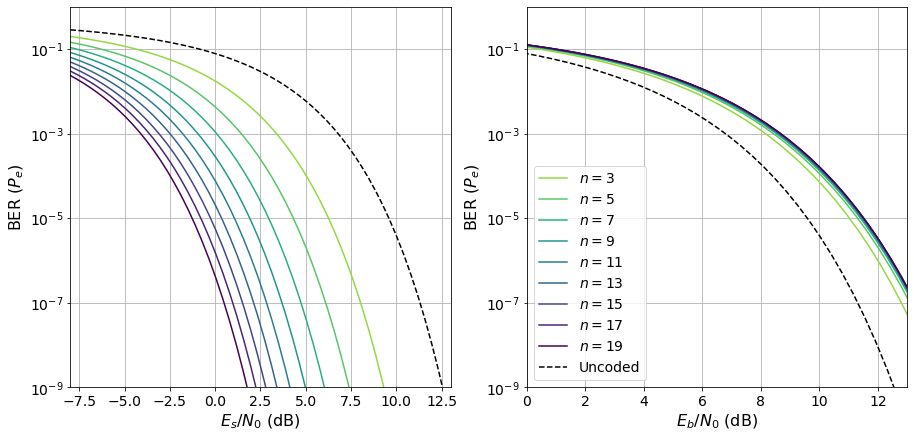

In [5]:
esno_dB_range = np.linspace(-18,20,100)

esno_linear_range = 10**(esno_dB_range/10)

# get delta from Es/N0, note that the Q function is norm.sf
delta_range = norm.sf(np.sqrt(2*esno_linear_range))


# range of repetition codfe lengths
n_range = np.arange(3,20,2)

fig,ax = plt.subplots(1,2, figsize=(15,7))
colors = plt.cm.viridis(np.linspace(1,0,20))

legend = []
for n in n_range:
    rate = 1/n
    
    # compute Eb/N0 with the corresponding rate
    ebno_dB_range = 10*np.log10(esno_linear_range / rate)
    
    # get error rate of repetition code 
    Pe = [1 - np.sum([comb(n,i,exact=False)*(delta**i)*((1-delta)**(n-i)) for i in range(0,(n-1)//2+1)]) for delta in delta_range]    
    
    ax[0].semilogy(esno_dB_range, Pe, color = colors[n])    
    ax[1].semilogy(ebno_dB_range, Pe, color = colors[n])
    legend.append('$n = %d$' % n)
    
ax[0].set_xlabel('$E_s/N_0$ (dB)', fontsize=16)
ax[1].set_xlabel('$E_b/N_0$ (dB)', fontsize=16)

for ai in range(2):
    # for uncoded transmission, Eb = Es
    ax[ai].semilogy(esno_dB_range, delta_range, 'k--')
    ax[ai].set_ylabel('BER ($P_e$)', fontsize=16)
    ax[ai].grid(True)
    ax[ai].set_ylim((1e-9,1))
    ax[ai].tick_params(labelsize=14)
    
legend.append('Uncoded')    
ax[0].set_xlim((-8,13))
ax[1].set_xlim((0,13))
ax[1].legend(legend,fontsize=14);

---
Show performance on the spectral efficiency chart at a target BER of $10^{-6}$. For this, we need to solve the the equation 
\begin{equation*}
P_e = 1 - \sum_{i=0}^{\lfloor\frac{n-1}{2}\rfloor}\binom{n}{i}\delta^i(1-\delta)^{n-i}
\end{equation*}
for $\delta$, which we can do numerically using the `fsolve` function.


In [6]:
from scipy.optimize import fsolve

def get_delta_from_Pe(Pe, n):
    func = lambda delta : Pe - 1 + np.sum([comb(n,i,exact=False)*(delta**i)*((1-delta)**(n-i)) for i in range(0,(n-1)//2+1)])    
    delta = fsolve(func, 0.4)
    return delta[0]
    

In [7]:
Pe_target = 1e-6;

esno_dB_range = np.linspace(-16,10,100)

# compute sigma_n
sigman_range = [np.sqrt(0.5 * 10**(-esno_db/10)) for esno_db in esno_dB_range]

delta_range = [norm.sf(1/sigman) for sigman in sigman_range]

capacity_AWGN = [0.5*np.log2(1+1/(sigman**2)) for sigman in sigman_range]
capacity_BIAWGN_hard = [1+delta*np.log2(delta)+(1-delta)*np.log2(1-delta) for delta in delta_range]

# repetition codes
rate_range = [1/n for n in n_range]
delta_for_Pe_range = [get_delta_from_Pe(Pe_target, n) for n in n_range]
esno_dB_for_Pe_range = [10*np.log10(0.5*np.square(norm.isf(delta))) for delta in delta_for_Pe_range]

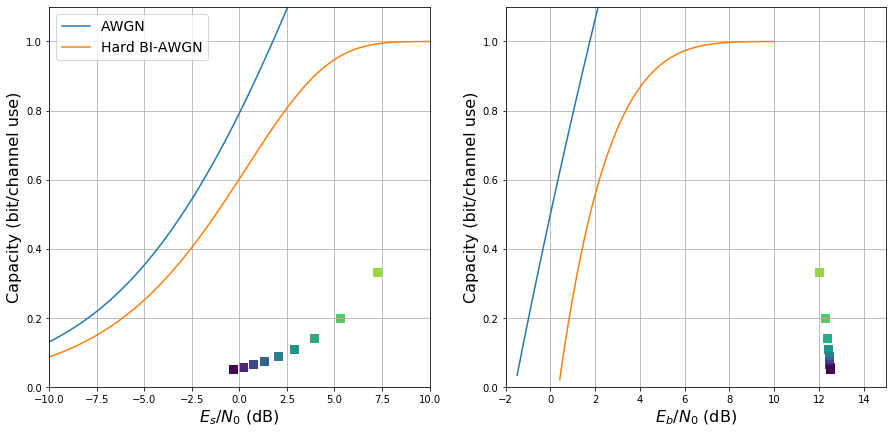

In [9]:
fig = plt.figure(1,figsize=(15,7))
plt.subplot(121)
plt.plot(esno_dB_range, capacity_AWGN)
plt.plot(esno_dB_range, capacity_BIAWGN_hard)
plt.scatter(esno_dB_for_Pe_range, rate_range, marker='s', c=colors[n_range,:], s=64)
plt.xlim((-10,10))
plt.ylim((0,1.1))
plt.xlabel('$E_s/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)
plt.legend(['AWGN', 'Hard BI-AWGN'],fontsize=14)

# plot Eb/N0 . Note that in this case, the rate that is used for calculating Eb/N0 is the capcity
# Eb/N0 = 1/r (Es/N0)
plt.subplot(122)
plt.plot(esno_dB_range - 10*np.log10(capacity_AWGN), capacity_AWGN)
plt.plot(esno_dB_range - 10*np.log10(capacity_BIAWGN_hard), capacity_BIAWGN_hard)
plt.scatter(esno_dB_for_Pe_range - 10*np.log10(rate_range), rate_range, marker='s', c=colors[n_range,:], s=64)

plt.xlim((-2,15))
plt.ylim((0,1.1))
plt.xlabel('$E_b/N_0$ (dB)',fontsize=16)
plt.ylabel('Capacity (bit/channel use)',fontsize=16)
plt.grid(True)

Show the performance also in the (unusual) spectral efficiency chart of the BSC.

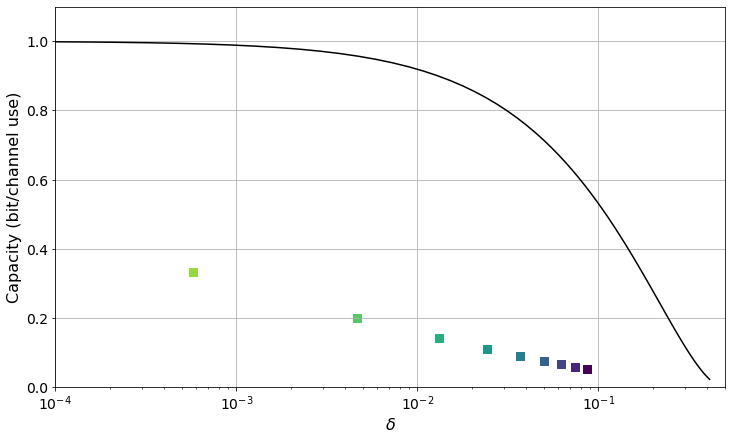

In [10]:
capacity_BSC = [1 + delta*np.log2(delta) + (1-delta)*np.log2(1-delta) for delta in delta_range]

fig = plt.figure(1,figsize=(12,7))
plt.semilogx(delta_range, capacity_BSC,'k-')
plt.scatter(delta_for_Pe_range, rate_range, marker='s', c=colors[n_range,:], s=64)

plt.xlim((1e-4,0.5))
plt.ylim((0,1.1))
plt.xlabel('$\delta$', fontsize=16)
plt.ylabel('Capacity (bit/channel use)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

***
## Performance on the Binary Erasure Channel (BEC)

Maximum likelihood of repetition codes on the BEC can be easily carried out. As the BEC doesn't introduce any errors, as soon as a single non-erased position is obtained, we can infer the value of the bit. The error probability is hence the probability that all positions are erased, i.e.,
$$
P_e = \frac12\epsilon^n
$$
In the case where everything is erased, we can still make a guess and will make a decoding error in $\frac12$ of the cases.

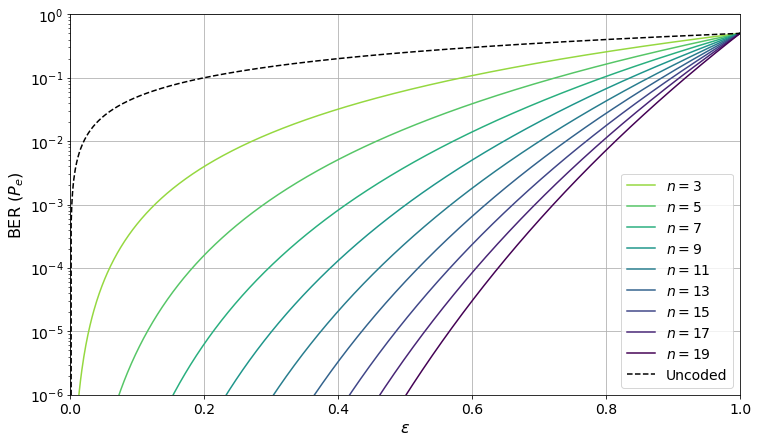

In [11]:
epsilon_range = np.linspace(0,1,1000)

fig = plt.figure(1,figsize=(12,7))

legend = [];
for n in n_range:
    # get error rate of repetition code 
    Pe = [0.5*epsilon**n for epsilon in epsilon_range]

    plt.semilogy(epsilon_range, Pe, color = colors[n])    
    legend.append('$n = %d$' % n)    

# In the case of uncoded transmission, we can guess the value of the bit in case of an erasure and we make a mistake in 50% of the cases, hence the error probability which is 0.5*epsilon
plt.semilogy(epsilon_range, 0.5*epsilon_range, 'k--')
legend.append('Uncoded')

plt.ylim((1e-6,1))    
plt.xlim((0,1))
plt.legend(legend,fontsize=14)
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('BER ($P_e$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('Repetition_BEC_BER.pdf',bbox_inches='tight')

Plot the performance of repetition codes on the binary erasure channel in the spectral efficiency chart. For a given target $P_e$, we can directly find the corresponding erasure probability as $\epsilon = \sqrt[n]{2P_e}$.

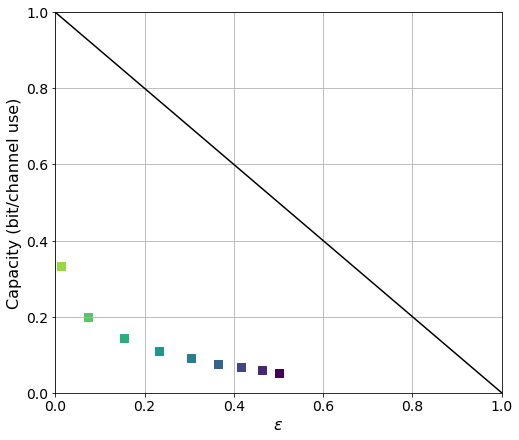

In [12]:
Pe_target =1e-6

fig = plt.figure(1,figsize=(8,7))
plt.plot(epsilon_range, 1-epsilon_range,'k-')

epsilon_for_Pe_range = [(2*Pe_target)**(1/n) for n in n_range]
plt.scatter(epsilon_for_Pe_range, rate_range, marker='s', s=64, c=colors[n_range,:])



plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('Capacity (bit/channel use)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('Repetition_BEC_SE.pdf',bbox_inches='tight')

***
## Performance on the Z-channel

Maximum likelihood of repetition codes on the BEC can be easily carried out. As shown in the tutorial, the error probability is hence the probability that the all-zero codeword is received, which is, assuming equiprobable codewords
$$
P_e = \frac12q^n
$$
where $q$ is the probability that a transmitted 1 is flipped to a 0 and where the factor $\frac12$ stems from the fact that in the case where the all-zero codeword is transmitted (with probability $\frac{1}{2}$, we never make an error with ML decoding, and hence we are only interested in the case where the all-1 codeword is transmitted

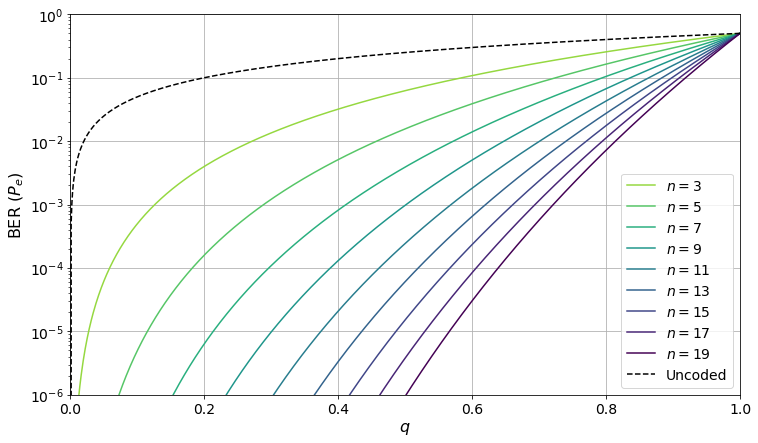

In [13]:
q_range = np.linspace(0,1,1000)

fig = plt.figure(1,figsize=(12,7))

legend = [];
for n in n_range:
    # get error rate of repetition code 
    Pe = [0.5*q**n for q in q_range]

    plt.semilogy(q_range, Pe, color = colors[n])    
    legend.append('$n = %d$' % n)    

# In the case of uncoded transmission, we can guess the value of the bit in case of an erasure and we make a mistake in 50% of the cases, hence the error probability which is 0.5*epsilon
plt.semilogy(q_range, 0.5*q_range, 'k--')
legend.append('Uncoded')

plt.ylim((1e-6,1))    
plt.xlim((0,1))
plt.legend(legend,fontsize=14)
plt.xlabel('$q$', fontsize=16)
plt.ylabel('BER ($P_e$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('Repetition_Z_BER.pdf',bbox_inches='tight')

Plot the spectral efficiency chart for the Z-channel. Assuming uniform input symbols $P(X=0)=P(X=1)=\frac12$, the mutual information $I(X;Y)$ for the Z-channel is given by
$$
I(X;Y) = h\left(\frac{1}{2}(1-q)\right) - \frac12h(q)
$$
with $h(x) := -x\log_2(x)-(1-x)\log_2(1-x)$ the binary entropy function.

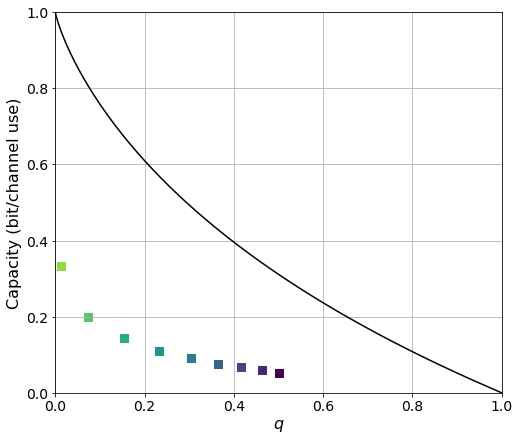

In [14]:
Pe_target =1e-6


fig = plt.figure(1,figsize=(8,7))


# Compute the achievable rate for the Z-channel with uniform inputs (P(X=0)=1/2) which is the mutual information I(X;Y)
hb = lambda x : -x*np.log2(x) - (1-x)*np.log2(1-x) if (x > 1e-20 and x < 1-1e-20) else 0
AchievableRate_Z = [hb(0.5*(1-q)) - 0.5*hb(q) for q in q_range]
plt.plot(q_range, AchievableRate_Z,'k-')

q_for_Pe_range = [(2*Pe_target)**(1/n) for n in n_range]
plt.scatter(q_for_Pe_range, rate_range, marker='s', s=64, c=colors[n_range,:])


plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('$q$', fontsize=16)
plt.ylabel('Capacity (bit/channel use)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
#plt.savefig('Repetition_Z_SE.pdf',bbox_inches='tight')